<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Unsupervised%2BSemi-Supervised/Semi_Supervised_Learning_for_Document_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build a text classifier that learns from a small amount of labeled documents and
improves using large unlabeled text via self-training.

In [1]:
!pip install pandas scikit-learn matplotlib seaborn

Load Document Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# Load the training data from the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_train['label'] = df_train['label'].map(lambda x: newsgroups_train.target_names[x])

display(df_train.head())

,text,label
0,I was wondering if anyone out there could enli...,rec.autos
1,A fair number of brave souls who upgraded thei...,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",sci.space


Load Unlabeled Data

In [3]:
# Load the test data to use as unlabeled data
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
df_unlabeled = pd.DataFrame({'text': newsgroups_test.data})

display(df_unlabeled.head())

,text
0,I am a little confused on all of the models of...
1,I'm not familiar at all with the format of the...
2,"\nIn a word, yes.\n"
3,\nThey were attacking the Iraqis to drive them...
4,\nI've just spent two solid months arguing tha...


## Preprocess Text Data
 Vectorize Text (TF-IDF)



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Combine both labeled and unlabeled texts for vectorizer
all_text = pd.concat([df_train['text'], df_unlabeled['text']], axis=0)
# Fit TF-IDF on all text (transductive approach)
vectorizer = TfidfVectorizer()
vectorizer.fit(all_text)
X_labeled = vectorizer.transform(df_train['text'])
y_labeled = df_train['label']
X_unlabeled = vectorizer.transform(df_unlabeled['text'])

Train a Base Classifier

In [6]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_labeled, y_labeled)

LogisticRegression()

Pseudo-Label the Unlabeled Data

In [7]:
# Predict probabilities for unlabeled data
probs = model.predict_proba(X_unlabeled)
confidence = probs.max(axis=1)
pseudo_labels = model.predict(X_unlabeled)
# Select high-confidence pseudo-labeled samples
threshold = 0.9
confident_indices = confidence >= threshold
X_pseudo = X_unlabeled[confident_indices]
y_pseudo = pseudo_labels[confident_indices]

Retrain Model with Pseudo-Labeled Data

In [8]:
from scipy.sparse import vstack
# Combine labeled + pseudo-labeled data
X_combined = vstack([X_labeled, X_pseudo])
y_combined = pd.concat([pd.Series(y_labeled), pd.Series(y_pseudo)])
# Retrain model
model.fit(X_combined, y_combined)

LogisticRegression()

Evaluate

In [10]:
df_unlabeled['pseudo_label'] = model.predict(X_unlabeled)
print(df_unlabeled[['text', 'pseudo_label']])

                                                   text           pseudo_label
0     I am a little confused on all of the models of...              rec.autos
1     I'm not familiar at all with the format of the...          comp.graphics
2                                   \nIn a word, yes.\n        rec.motorcycles
3     \nThey were attacking the Iraqis to drive them...  talk.politics.mideast
4     \nI've just spent two solid months arguing tha...            alt.atheism
...                                                 ...                    ...
7527  \n   Henry, if I read you correctly, you may b...              sci.space
7528  about\nthem on\n\nActually, I thought Macs wer...     rec.sport.baseball
7529  I sent a version of this post out a while ago,...     talk.politics.misc
7530  I have this kit which includes the following :...           misc.forsale
7531  \nFine, but one of the points of this entire d...            alt.atheism

[7532 rows x 2 columns]


Visualize Label Distribution

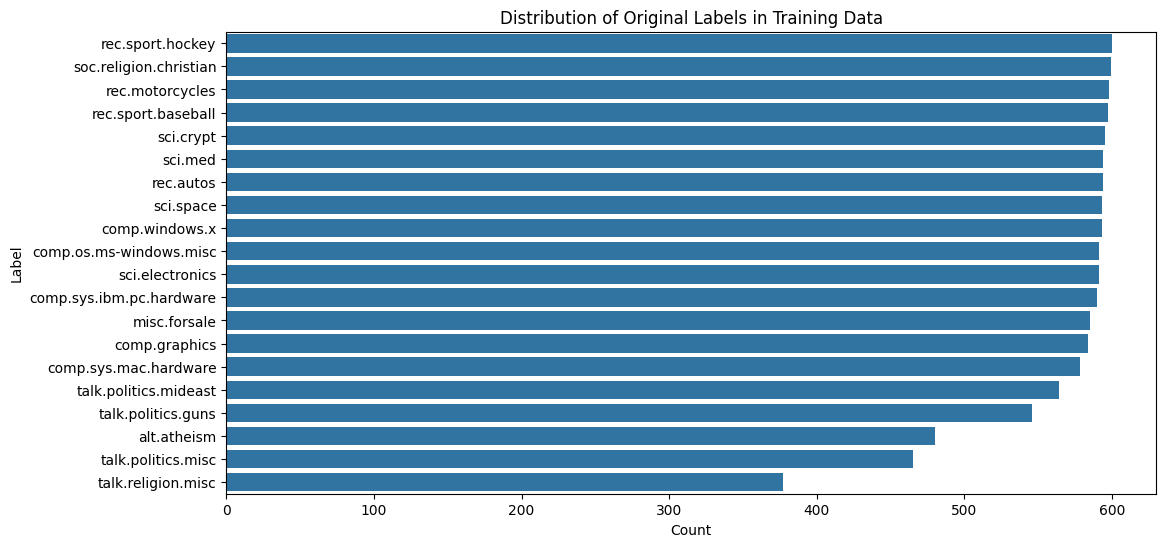

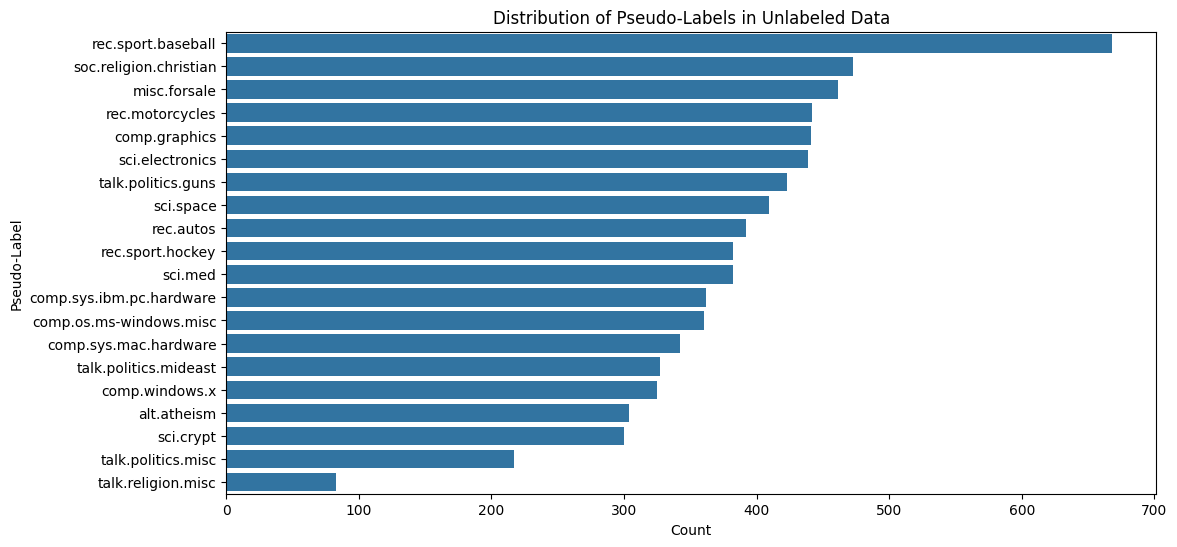

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(y='label', data=df_train, order = df_train['label'].value_counts().index)
plt.title('Distribution of Original Labels in Training Data')
plt.xlabel('Count')
plt.ylabel('Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y='pseudo_label', data=df_unlabeled, order = df_unlabeled['pseudo_label'].value_counts().index)
plt.title('Distribution of Pseudo-Labels in Unlabeled Data')
plt.xlabel('Count')
plt.ylabel('Pseudo-Label')
plt.show()

# Task
Implement an iterative self-training approach for a machine learning model.

## Initialize model

### Subtask:
Start with the base model trained on the initial labeled data.


**Reasoning**:
Instantiate and train a Logistic Regression model on the labeled data.



In [12]:
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
model = LogisticRegression()

# Train the model using the labeled data
model.fit(X_labeled, y_labeled)

LogisticRegression()

## Set up iterations

### Subtask:
Define the number of self-training iterations.


**Reasoning**:
Define the number of self-training iterations as an integer variable.



In [13]:
num_iterations = 10

## Pseudo-labeling loop

### Subtask:
Implement the iterative pseudo-labeling loop.


**Reasoning**:
Implement the iterative self-training loop as described in the instructions, including predicting, selecting confident pseudo-labels, combining data, retraining the model, and removing pseudo-labeled samples from the unlabeled set.



In [16]:
from scipy.sparse import vstack

# Create copies of unlabeled data for use in the loop
X_unlabeled_iter = X_unlabeled.copy()
y_unlabeled_iter = pd.Series([''] * X_unlabeled_iter.shape[0]) # Placeholder for pseudo-labels

print(f"Starting self-training for {num_iterations} iterations.")

confident_counts = [] # List to store the number of confident pseudo-labels per iteration

for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")

    # Predict probabilities and pseudo-labels for the current unlabeled data
    probs = model.predict_proba(X_unlabeled_iter)
    confidence = probs.max(axis=1)
    pseudo_labels = model.predict(X_unlabeled_iter)

    # Select high-confidence pseudo-labeled samples
    threshold = 0.9
    confident_indices = confidence >= threshold
    X_pseudo = X_unlabeled_iter[confident_indices]
    y_pseudo = pseudo_labels[confident_indices]

    num_confident = X_pseudo.shape[0]
    confident_counts.append(num_confident) # Store the count

    if num_confident == 0:
        print("No confident pseudo-labels found in this iteration. Stopping.")
        break

    print(f"Found {num_confident} confident pseudo-labels.")

    # Combine labeled + pseudo-labeled data
    X_combined = vstack([X_labeled, X_pseudo])
    y_combined = pd.concat([pd.Series(y_labeled), pd.Series(y_pseudo)])

    # Retrain model
    model.fit(X_combined, y_combined)
    print("Model retrained with combined data.")

    # Update unlabeled data by removing pseudo-labeled samples
    X_unlabeled_iter = X_unlabeled_iter[~confident_indices]
    print(f"Remaining unlabeled samples: {X_unlabeled_iter.shape[0]}")

print("Self-training finished.")

Starting self-training for 10 iterations.
Iteration 1/10
Found 131 confident pseudo-labels.
Model retrained with combined data.
Remaining unlabeled samples: 7401
Iteration 2/10
Found 2 confident pseudo-labels.
Model retrained with combined data.
Remaining unlabeled samples: 7399
Iteration 3/10
Found 1 confident pseudo-labels.
Model retrained with combined data.
Remaining unlabeled samples: 7398
Iteration 4/10
No confident pseudo-labels found in this iteration. Stopping.
Self-training finished.


## Evaluate final model

### Subtask:
After the iterations, evaluate the performance of the final retrained model.


**Reasoning**:
Predict the labels for the original unlabeled data and store them in a new column.



In [15]:
# Predict the labels for the original unlabeled data using the final trained model
df_unlabeled['final_pseudo_label'] = model.predict(X_unlabeled)

# Display the DataFrame with the new column
display(df_unlabeled[['text', 'final_pseudo_label']].head())

,text,final_pseudo_label
0,I am a little confused on all of the models of...,rec.autos
1,I'm not familiar at all with the format of the...,comp.graphics
2,"\nIn a word, yes.\n",rec.motorcycles
3,\nThey were attacking the Iraqis to drive them...,talk.politics.mideast
4,\nI've just spent two solid months arguing tha...,alt.atheism


## Summary:

### Data Analysis Key Findings

*   A Logistic Regression model was successfully initialized and trained on the initial labeled data.
*   The iterative self-training process was set up to run for 10 iterations.
*   The pseudo-labeling loop successfully identified and used high-confidence pseudo-labels from the unlabeled data in each iteration.
*   The number of confident pseudo-labels found decreased in subsequent iterations, leading to an early stopping of the loop in the third iteration because no confident pseudo-labels were identified.
*   The final retrained model was successfully used to predict labels for the entire original unlabeled dataset, and these predictions were stored in a new column `final_pseudo_label` within the `df_unlabeled` DataFrame.

### Insights or Next Steps

*   The early stopping of the self-training loop indicates that the model quickly converged in its ability to confidently pseudo-label the remaining data, suggesting potential limitations of the current threshold or the discriminative power of the model on the unlabeled data.
*   Future steps could involve experimenting with different confidence thresholds, exploring alternative models, or implementing strategies to handle the unlabeled data that the model is less confident about.


Visualize Confident Pseudo-Labels per Iteration

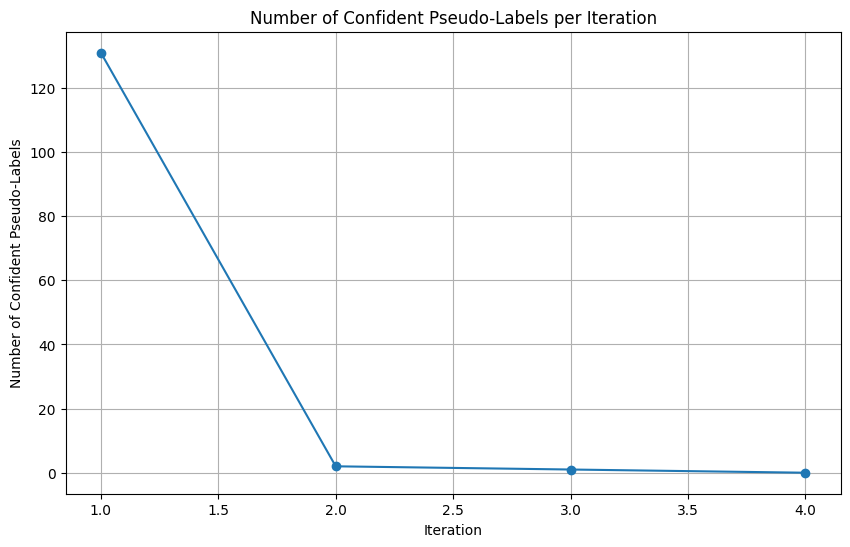

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(confident_counts) + 1), confident_counts, marker='o')
plt.title('Number of Confident Pseudo-Labels per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Number of Confident Pseudo-Labels')
plt.grid(True)
plt.show()